In [1]:
# Here we import everything we need for the project

%matplotlib inline
import os, time
import csv

# pytorch
import torch
from torch.nn import Module, Conv2d, MaxPool2d, Linear
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split # Helps with organizing data for training
from sklearn.metrics import confusion_matrix, classification_report # Helps present results as a confusion-matrix

## Writing CSV - ASL Dataset
Since this dataset doesn't come with a nice csv, write one ourselves to make loading the data easier later
Note: directly setting filepaths to the pre-binarized images so we don't need to perform this operation ourselves

In [38]:
header = ["path_to_file", "GT"]
csv_path = "./data/asl/asl_images.csv"
imagepaths = []
fnames = []
# these are 400x400 BW images
root = "./data/asl/asl_data/binary_frames_rotated"

for dirname, dirs, files in os.walk(root):
    for fname in files:
        if fname.endswith(".png"):
            fnames.append(fname)
        path = os.path.join(dirname, fname)
        if path.endswith(".png"):
            imagepaths.append(path)

gt = [fname.split('_')[0] for fname in fnames]
with open(csv_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(header)
    for i, fpath in enumerate(imagepaths):
        writer.writerow([fpath, gt[i]])

## Dataloaders
To facilitate using pytorch to build our cnn, we write a custom DataLoader class. This allows for on-demand loading of images, which are used to train our cnn.

In [39]:
class AslGestureDataset(Dataset):
    """Custom loader for the Kaggle Hand Detection Dataset"""
    
    def __init__(self, csv_file, transforms=None):
        """
        Args:
            csv_file (string): Path to the csv file with image filepaths and gt classes
            transforms (callable, optional): Optional transforms to be applied on a sample
        """
        self.images_frame = pd.read_csv(csv_file)
        self.transforms = transforms
        
    def __len__(self):
        return len(self.images_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = self.images_frame.iloc[idx, 0]
        #print(img_name)
        img = cv2.imread(img_name)
        y = (self.images_frame.iloc[idx, 1])
        # normalize to 0-26 for classes (missing j and z b/c dynamic)
        y = ord(y)- ord('a')
        sample = {'image' : img, 'y' : y, 'fname' : img_name}
        
#         print(sample)
        
        if len(self.transforms) > 0:
            for _, transform in enumerate(self.transforms):
                sample = transform(sample)
        return sample

In [40]:
class Rescale(object):
    """Used to rescale an image to a given size. Useful for the CNN
    
    Args:
        output_size (tuple or int): Desired output size after rescaling. If tuple, output is matched to output_size.
        If int smaller of width/height is matched to output_size, keeping aspect ratio the same.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        y = sample['y']
        image = sample['image']
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h // w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w // h
        else:
            new_h, new_w = self.output_size
        
        img = cv2.resize(image, (new_h, new_w))
        #print(f"after resize: {img.shape}")
        return {'image' : img, 'y' : y, 'fname' : sample['fname']}
    
class Recolor(object):
    """Used to recolor an image using cv2
    
    Args:
        flag (cv2.COLOR_): color to swap to
    """
    def __init__(self, color):
        self.color = color
    
    def __call__(self, sample):
        y = sample['y']
        image = sample['image']
        #print(f"before recolor: {image.shape}")
        
        # cvtColor to gray drops the damned channel dimension but we need it
        img_cvt = cv2.cvtColor(image, self.color)
        # fucking hack an extra dim to appease pytorch's bitchass
        img_cvt = np.expand_dims(img_cvt, axis=-1)
        #print(f"after exansion: {img_cvt.shape}")
        return {'image' : img_cvt, 'y' : y, 'fname' : sample['fname']}

class ToTensor(object):
    """Convert ndarrays to pytorch Tensors"""
    
    def __call__(self, sample):
        y = sample['y']
        image = sample['image']
        
        # swap color axis b/c 
        # numpy img: H x W x C
        # torch img: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image' : torch.from_numpy(image), 'y' : y, 'fname' : sample['fname']}

In [41]:
def prediction_to_class_str(pred):
    classes = {0 : "palm", 1 : "L", 2 : "fist", 3 : "fist_moved", 4 : "thumb", 5 : "index", 6 : "ok", 7 : "palm_moved", 8 : "c", 9 : "down"}
    return classes[pred]

def classify_arbitrary_image(model, img):
    img_type = type(img)
    print(img_type)
    if img_type == torch.Tensor:
        print("tensor")
        img = img.float()
        img = img.unsqueeze(1)
    elif img_type == np.ndarray:
        print("np array")
        img = np.expand_dims(img, 1)
    else:
        print("error: something other than a torch.Tensor or an np.ndarray was passed as img")
    prediction = model(img)
    prediction = prediction.data.numpy()
    y_hat = np.argmax(prediction, axis=1)
    return prediction_to_class_str(y_hat[0])

def classify_many_images(model, imgs):
    # for now, assuming imgs is a list of images that are either np.ndarrays or torch.Tensors
    # labels will be given back in order images were given
    predictions = []
    for img in imgs:
        predictions.append(classify_arbitrary_image(model, img))
    return predictions

def get_model_acc(model, data_loader):
    total_samples = 0
    total_misclass = 0
    all_y = np.array([], dtype=np.uint8)
    all_y_hat = np.array([], dtype=np.uint8)
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        model = model.cuda()
    else:
        model = model.cpu()
    for i, sample in enumerate(data_loader):
        y = sample['y']
        y = y.data.numpy()
        images = (sample['image'])
        if use_cuda:
            images = images.cuda()
            
        images = images.float()
        predictions = model(images)
        predictions = predictions.cpu()
        predictions = predictions.data.numpy()
        y_hat = np.argmax(predictions, axis=1)
        misclass = np.sum(np.where(y != y_hat, 1, 0))
        total_samples += y.shape[0]
        total_misclass += misclass
        all_y = np.append(all_y, y)
        all_y_hat = np.append(all_y_hat, y_hat)
        #print(f"all_y = {all_y}")
        #print(f"all_y_hat = {all_y_hat}")
        print(f"Number of Misclassifications = {misclass}")
        print(f"Sample acc = {(y.shape[0]-misclass)/y.shape[0]*100}")
    overall_acc = (total_samples - total_misclass)/total_samples
    print(f"Overall Accuracy = {overall_acc}")
    return all_y, all_y_hat, overall_acc

In [42]:
class HandNNModel(Module):
    def __init__(self):
        super().__init__()
        
        # input shape = (32, 256, 256) - (batch_size, w, h) from dataloader
        self.conv1 = Conv2d(1, 32, kernel_size=5) # output shape: (252, 252, 32)
        self.pool1 = MaxPool2d(2) # output shape: (121, 121, 32)
        self.conv2 = Conv2d(32, 64, kernel_size=3) # output shape: (119, 119, 64)
        self.pool2 = MaxPool2d(2) # output shape: (59, 59, 64) - torch uses floor by default
        self.conv3 = Conv2d(64, 64, kernel_size=3) # output shape: (57, 57, 64)
        self.pool3 = MaxPool2d(2) # output shape: (28, 28, 64)
        self.fc1 = Linear(28*28*64, 128) # output shape: (28*28*64, 128)
        self.fc2 = Linear(128, 10)
        self.activation = torch.nn.ReLU()
        
    def forward(self, X):
        X = self.activation(self.conv1(X))
        X = self.pool1(X)
        X = self.activation(self.conv2(X))
        X = self.pool2(X)
        X = self.activation(self.conv3(X))
        X = self.pool3(X)
        X = torch.flatten(X, 1) # flatten with start_dim = 1
        X = self.fc1(X)
        X = self.fc2(X)
        output = F.softmax(X)
        return output

In [43]:
class AslNNModel(Module):
    # same structure as HandNNModel, need to change dimensions
    def __init__(self):
        super().__init__()
        
        # input shape = (64, 400, 400) - (batch_size, w, h) from dataloader
        self.conv1 = Conv2d(1, 32, kernel_size=5) # output shape: (496, 496, 32)
        self.pool1 = MaxPool2d(2) # output shape: (198, 198, 32)
        self.conv2 = Conv2d(32, 64, kernel_size=3) # output shape: (196, 196, 64)
        self.pool2 = MaxPool2d(2) # output shape: (98, 98, 64) - torch uses floor by default
        self.conv3 = Conv2d(64, 64, kernel_size=3) # output shape: (96, 96, 64)
        self.pool3 = MaxPool2d(2) # output shape: (48, 48, 64)
        self.fc1 = Linear(48*48*64, 128) # output shape: (48*48*64, 128)
        self.fc2 = Linear(128, 26) # 24 possible output classes, but it goes up to idx 26: CUDA screams otherwise, so here we are
        self.activation = torch.nn.ReLU()
        
    def forward(self, X):
        X = self.activation(self.conv1(X))
        X = self.pool1(X)
        X = self.activation(self.conv2(X))
        X = self.pool2(X)
        X = self.activation(self.conv3(X))
        X = self.pool3(X)
        X = torch.flatten(X, 1) # flatten with start_dim = 1
        X = self.fc1(X)
        X = self.fc2(X)
        output = F.softmax(X)
        return output

In [44]:
def make_asl_count_df(y):
    counts = np.zeros(26)
    y = np.array(y)
    for i in range(26):
        counts[i] = np.sum(np.where(y == i, 1, 0))
    idx = [chr(i) for i in range(97, 123)]
    columns=["Count"]
    df = pd.DataFrame(counts, index=idx, columns=columns)
    return df

def y_as_np_arr(dataset):
    return np.array([sample['y'] for sample in dataset])


def make_asl_train_test_split(dataset, counts_df, split_ratio=0.75, train_csv="./data/asl/train_asl.csv", test_csv="./data/asl/test_asl.csv"):
    header = ["path_to_file", "GT"]
    train = []
    test = []
    np.random.seed(0)
    train_counts, test_counts = [int(np.ceil(split_ratio*counts_df.iloc[idx, 0])) for idx in range(counts_df.shape[0])], [int(np.floor((1-split_ratio)*counts_df.iloc[idx, 0])) for idx in range(counts_df.shape[0])]
    y = y_as_np_arr(dataset)
    for idx in range(counts_df.shape[0]):
        #curr_train_selections = []
        #curr_test_selections = []
        only_class_locs = np.where(y==idx)[0]
        train_idxes = np.random.choice(only_class_locs, size=train_counts[idx], replace=False)
        for data_idx in only_class_locs:
            sample = dataset[data_idx]
            if data_idx in train_idxes:
                #curr_train_selections.append(sample['fname'])
                train.append(sample['fname'])
            else:
                #curr_test_selections.append(sample['fname'])
                test.append(sample['fname'])
        #train.append(curr_train_selections)
        #test.append(curr_test_selections)
#     train_lasts = [fname.split('/')[-1] for fname in train]
    train_gt = [os.path.split(fname)[-1].split('_')[0] for fname in train]
#     test_lasts = [fname.split('/')[-1] for fname in test]
    test_gt = [os.path.split(fname)[-1].split('_')[0] for fname in test]
    with open(train_csv, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(header)
        for i, fpath in enumerate(train):
            writer.writerow([fpath, train_gt[i]])
    with open(test_csv, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(header)
        for i, fpath in enumerate(test):
            writer.writerow([fpath, test_gt[i]])
    return train, test



#print(test)

#lasts = [fname.split('/')[-1] for fname in test]
#gt = [fname.split('_')[0] for fname in lasts]
#print(len(gt))
#train_asl_dataset = AslGestureDataset(csv_file="./data/asl/train_asl.csv", transforms=[recolor, to_tensor])
#print(len(train_asl_dataset))
#plt.imshow(np.squeeze(test[0][0]['image'].numpy()))

In [45]:
resize = Rescale((256,256))
recolor = Recolor(cv2.COLOR_BGR2GRAY)
to_tensor = ToTensor()
transforms = [resize, recolor, to_tensor]

In [46]:
asl_dataset = AslGestureDataset(csv_file="./data/asl/asl_images.csv", transforms=[recolor, to_tensor])

In [47]:
y = y_as_np_arr(asl_dataset)
df = make_asl_count_df(y)

In [48]:
train, test = make_asl_train_test_split(asl_dataset, df)

## Confusion Matrix and Classification Report (from sklearn)


In [49]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

alphabet = [chr(l) for l in range(ord('a'), ord('z') +1)]
alphabet_reduced = [chr(l) for l in range(ord('a'), ord('z') +1)]
alphabet_reduced.remove("j")
alphabet_reduced.remove("z")

def make_stats(y, y_hat, num_classes=10):
    cm = confusion_matrix(y, y_hat)
    cm_df = pd.DataFrame(cm, columns=[str(i) for i in range(num_classes)])
    report = classification_report(y, y_hat)
    if num_classes == 24:
        cm_df.index = alphabet_reduced
        cm_df.columns = alphabet_reduced
    else:
        cm_df.index = alphabet[:num_classes]
        cm_df.columns = alphabet[:num_classes]
#     print(cm_df.to_markdown())
    for cl, lt in enumerate(alphabet):
        cl_str = f' {cl} '
        lt_str = f' {lt} '
        lt_str = ' '*(len(cl_str) - len(lt_str)) + lt_str
        report = report.replace(cl_str, lt_str)
        
    return cm_df, report

## Train the model using the Custom Dataloader
Below, we will actually train our CNN model

In [50]:
train_loss = []
test_loss = []

In [51]:
batch = 48
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
if use_cuda:
    params = {'batch_size' : batch, 'shuffle': True, 'num_workers' : 0, 'pin_memory' : True}
else:
    params = {'batch_size' : batch, 'shuffle': True, 'num_workers' : 0}
def train_model(model, train_data_loader, test_data_loader, max_epochs, use_cuda, save_path='trained_model.pkl', save=True):
    if use_cuda:
        model.cuda()

    print(model.eval())
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    start = time.time()
    for epoch in range(max_epochs):
        print(f"start epoch {epoch}")
        running_loss_train = 0.0
        count_train = 0
        epoch_start_train = time.time()
        for i, data in enumerate(train_data_loader):
            imgs, labels = data['image'], data['y']
            # move to GPU
            imgs, labels = imgs.cuda(), labels.cuda()
            imgs = imgs.float()
            optimizer.zero_grad()

            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss_train += loss.item()
            count_train = i + 1
            if i % 50 == 0:
                print(f"epoch {epoch} {count_train * batch}: train running loss = {running_loss_train/count_train}")
                print(f"epoch {epoch} {count_train * batch}: train testing runtime = {time.time() - epoch_start_train}")
        epoch_end_train = time.time()
        print(f"epoch {epoch}  {count_train * batch}: Train Final loss = {running_loss_train/count_train}")
        train_loss.append(running_loss_train/count_train)
        print(f"epoch {epoch}  {count_train * batch}: Train runtime = {epoch_end_train - epoch_start_train}")
        # ====================Test data=================
        running_loss_test = 0.0
        count_test = 0
        epoch_start_test = time.time()
        for i, data in enumerate(test_data_loader):
            imgs, labels = data['image'], data['y']
            # move to GPU
            imgs, labels = imgs.cuda(), labels.cuda()
            imgs = imgs.float()
            optimizer.zero_grad()

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss_test += loss.item()
            count_test = i + 1
            if i % 50 == 0:
                print(f"epoch {epoch} {count_test * batch}: testing running loss = {running_loss_test/count_test}")
                print(f"epoch {epoch} {count_test * batch}: testing runtime = {time.time() - epoch_start_test}")
        epoch_end_test = time.time()
        print(f"epoch {epoch} {count_test * batch}: Testing Final loss = {running_loss_test/count_test}")
        test_loss.append(running_loss_test/count_test)
        print(f"epoch {epoch} {count_test * batch}: Testing runtime = {epoch_end_test - epoch_start_test}")
    end = time.time()
    print(f"Total training time = {end - start}")

    # make sure to save the model so we don't need to train again
    if save:
        torch.save(model.state_dict(), save_path)

## Train our Model on the Dataset

In [52]:
train_asl_dataset = AslGestureDataset(csv_file="./data/asl/train_asl.csv", transforms=[recolor, to_tensor])
test_asl_dataset = AslGestureDataset(csv_file="./data/asl/test_asl.csv", transforms=[recolor, to_tensor])
test_data_loader = DataLoader(test_asl_dataset, **params)
train_data_loader = DataLoader(train_asl_dataset, **params)

In [53]:
# max_epochs = 400 
# asl_model = AslNNModel()

# save_path='./data/asl/asl_train_no_tl_same_model_tmp.pkl'
# train_model(asl_model, train_data_loader, max_epochs, use_cuda, save_path='./data/asl/asl_train_no_tl_same_model.pkl')
# asl_train_all_y, asl_train_all_y_hat, asl_train_acc = get_model_acc(asl_model, train_data_loader)
# cm_df, report = make_stats(asl_train_all_y, asl_train_all_y_hat, num_classes=24)
# print(cm_df.to_markdown())
# print(report)

In [54]:
# asl_test_all_y, asl_test_all_y_hat, asl_test_acc = get_model_acc(asl_model, test_data_loader)
# cm_df, report = make_stats(asl_test_all_y, asl_test_all_y_hat, num_classes=24)
# print(cm_df.to_markdown())
# print(report)

In [55]:
# loaded_model = AslNNModel()
# loaded_model.load_state_dict(torch.load(save_path))

## Using AlexNet
This has already been implemented in pytorch, so we are exploring using this CNN model with our datset

### Baseline: Literally just loading AlexNet and making predicitions
To have a baseline comparison, we will first just use AlexNet (pretrained on ImageNet dataset) to make predictions. We don't expect this to do well at all

In [56]:
import torchvision
alexnet_model = torchvision.models.alexnet(pretrained=True)
# update model to have a single layer input, not 3 layer (AlexNet expects 3 channel RGB images as input)
alexnet_model.features[0] = Conv2d(1, 64, kernel_size=(11,11), stride=(4,4), padding=(2,2))
# update model to have 26 possible output classes, one per letter
alexnet_model.classifier[6] = torch.nn.Linear(4096, 26)
print(alexnet_model.eval())


AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [57]:
# print(len(train_asl_dataset))
# alexnet_train_all_y, alexnet_train_all_y_hat, alexnet_train_acc = get_model_acc(alexnet_model, train_data_loader)
# cm_df, report = make_stats(alexnet_train_all_y, alexnet_train_all_y_hat, num_classes=24)
# print(cm_df.to_markdown())
# print(report)

### Second Approach: Transfer Learning from the Pretrained AlexNet model 
This won't be a full train from scratch, but techinically transfer learning from the Pretrained AlexNet model.
We will train AlexNet on our ASL dataset, starting from the already trained AlexNet model on ImageNet

In [58]:
max_epochs = 28 

In [59]:
train_model(alexnet_model, train_data_loader, test_data_loader, max_epochs, use_cuda, save_path='./Models/Asl_AdamNet_training.pkl')

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [60]:
alexnet_tl_train_all_y, alexnet_tl_train_all_y_hat, alexnet_tl_train_acc = get_model_acc(alexnet_model, train_data_loader)

Number of Misclassifications = 0
Sample acc = 100.0
Number of Misclassifications = 0
Sample acc = 100.0
Number of Misclassifications = 0
Sample acc = 100.0
Number of Misclassifications = 0
Sample acc = 100.0
Number of Misclassifications = 0
Sample acc = 100.0
Number of Misclassifications = 0
Sample acc = 100.0
Number of Misclassifications = 0
Sample acc = 100.0
Number of Misclassifications = 0
Sample acc = 100.0
Number of Misclassifications = 0
Sample acc = 100.0
Number of Misclassifications = 0
Sample acc = 100.0
Number of Misclassifications = 0
Sample acc = 100.0
Number of Misclassifications = 0
Sample acc = 100.0
Number of Misclassifications = 0
Sample acc = 100.0
Number of Misclassifications = 0
Sample acc = 100.0
Number of Misclassifications = 0
Sample acc = 100.0
Overall Accuracy = 1.0


In [61]:
alexnet_tl_test_all_y, alexnet_tl_test_all_y_hat, alexnet_tl_test_acc = get_model_acc(alexnet_model, test_data_loader)

Number of Misclassifications = 4
Sample acc = 91.66666666666666
Number of Misclassifications = 3
Sample acc = 93.75
Number of Misclassifications = 5
Sample acc = 89.58333333333334
Number of Misclassifications = 2
Sample acc = 95.83333333333334
Number of Misclassifications = 5
Sample acc = 89.58333333333334
Overall Accuracy = 0.9208333333333333


In [62]:
cm_df, report = make_stats(alexnet_tl_train_all_y, alexnet_tl_train_all_y_hat, num_classes=24)
print(cm_df.to_markdown())
print(report)

|    |   a |   b |   c |   d |   e |   f |   g |   h |   i |   k |   l |   m |   n |   o |   p |   q |   r |   s |   t |   u |   v |   w |   x |   y |
|:---|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|
| a  |  30 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |
| b  |   0 |  30 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |
| c  |   0 |   0 |  30 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |
| d  |   0 |   0 |   0 |  30 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |
| e  |   0 |   0 |   0 |   0 |  30 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0

In [63]:
cm_df, report = make_stats(alexnet_tl_test_all_y, alexnet_tl_test_all_y_hat, num_classes=24)
print(cm_df.to_markdown())
print(report)

|    |   a |   b |   c |   d |   e |   f |   g |   h |   i |   k |   l |   m |   n |   o |   p |   q |   r |   s |   t |   u |   v |   w |   x |   y |
|:---|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|----:|
| a  |  10 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |
| b  |   0 |   9 |   0 |   0 |   0 |   1 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |
| c  |   0 |   0 |  10 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |
| d  |   0 |   0 |   0 |   9 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   1 |   0 |   0 |   0 |
| e  |   0 |   0 |   0 |   0 |   8 |   0 |   0 |   0 |   0 |   0 |   0 |   2 |   0 |   0 |   0

### Third Approach: Transfer Learning from the Kaggle Dataset
For comparison to the TL trained AlexNet model, we will also be retraining the same style CNN as part 1 of our project, but using TL from our first model.
In other words, we will be starting from the pretrained model on the Kaggle Dataset, and training a new model to recognize the ASL alphabet
JK I'm not going through this headache - would basically need to redo every layer to match asl model to actually get it working, too much of a pita so not even gonna try
We're just gonna say too hard in report

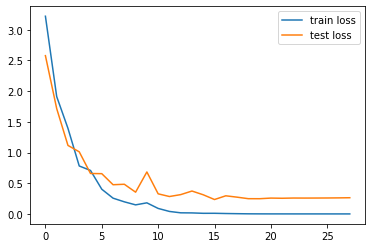

In [64]:
import matplotlib.pyplot as plt

iterations = np.arange(len(train_loss))
# plot lines
plt.plot(iterations, train_loss, label = "train loss")
plt.plot(iterations, test_loss, label = "test loss")
plt.legend()
plt.show()